In [1]:
import chromatix.functional as cf
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tensor_tomo import PTFT

%config InlineBackend.figure_format='retina'

Let's first compare on an artifically made grid:

In [2]:
# We set km = 1 so that all frequencies run from -1 to 1.
k = jnp.linspace(-1.2, 1.2, 1024)
k_rel = jnp.stack(jnp.meshgrid(k[::-1], k, indexing="ij"), axis=0) # we set y from bottom to top

# Adding in kz
kz = jnp.sqrt(jnp.maximum(0.0, 1.0 - jnp.sum(k_rel**2, axis=0, keepdims=True)))
k_rel = jnp.concatenate([kz, k_rel], axis=0)

print(f"Shape of k grid: {k_rel.shape}")


Shape of k grid: (3, 1024, 1024)


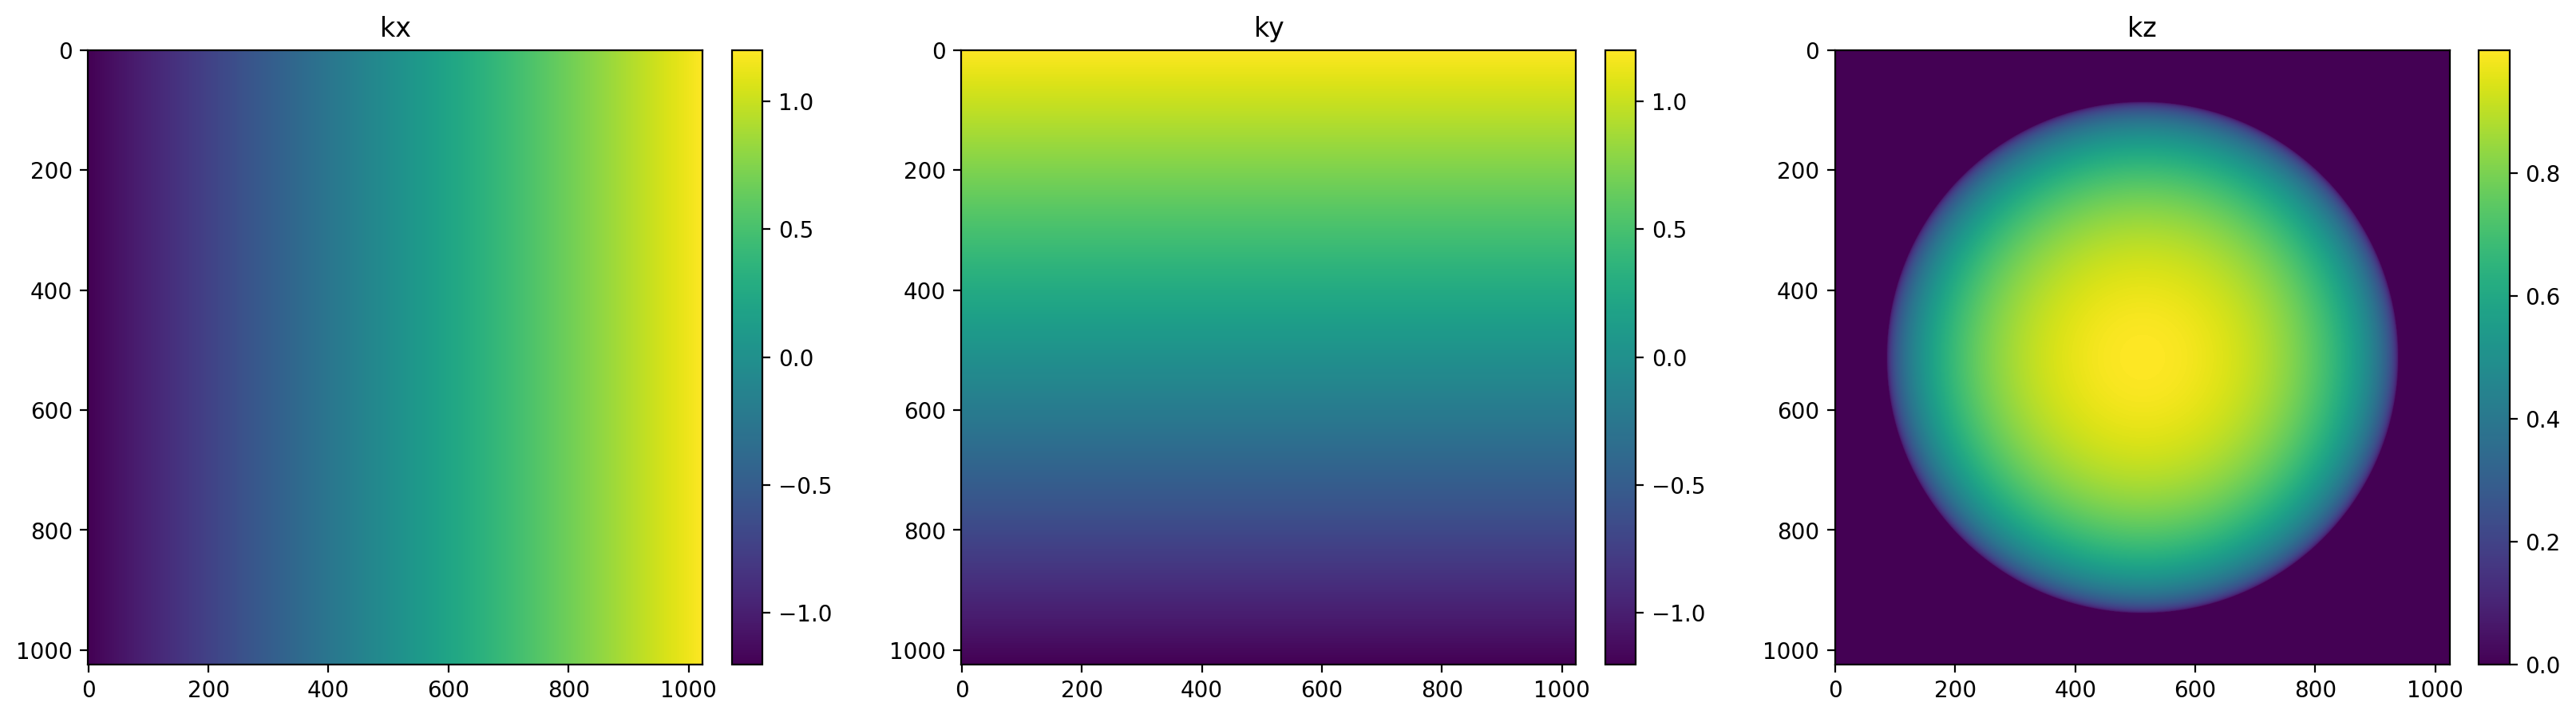

In [3]:
# Quick check if our coordinates are where they should be
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(k_rel[2])
plt.title("kx")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(k_rel[1])
plt.title("ky")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(k_rel[0])
plt.title("kz")
plt.colorbar(fraction=0.046, pad=0.04)

In [4]:
# Getting Q 
Q = PTFT(k_rel, km=1)

print(f"Shape of Polarisation Transfer Function Tensor: {Q.shape}")


# We set 0 to NaN to plot clearer
Q_plot = jnp.where(Q == 0, jnp.nan, Q)

Shape of Polarisation Transfer Function Tensor: (1024, 1024, 3, 3)


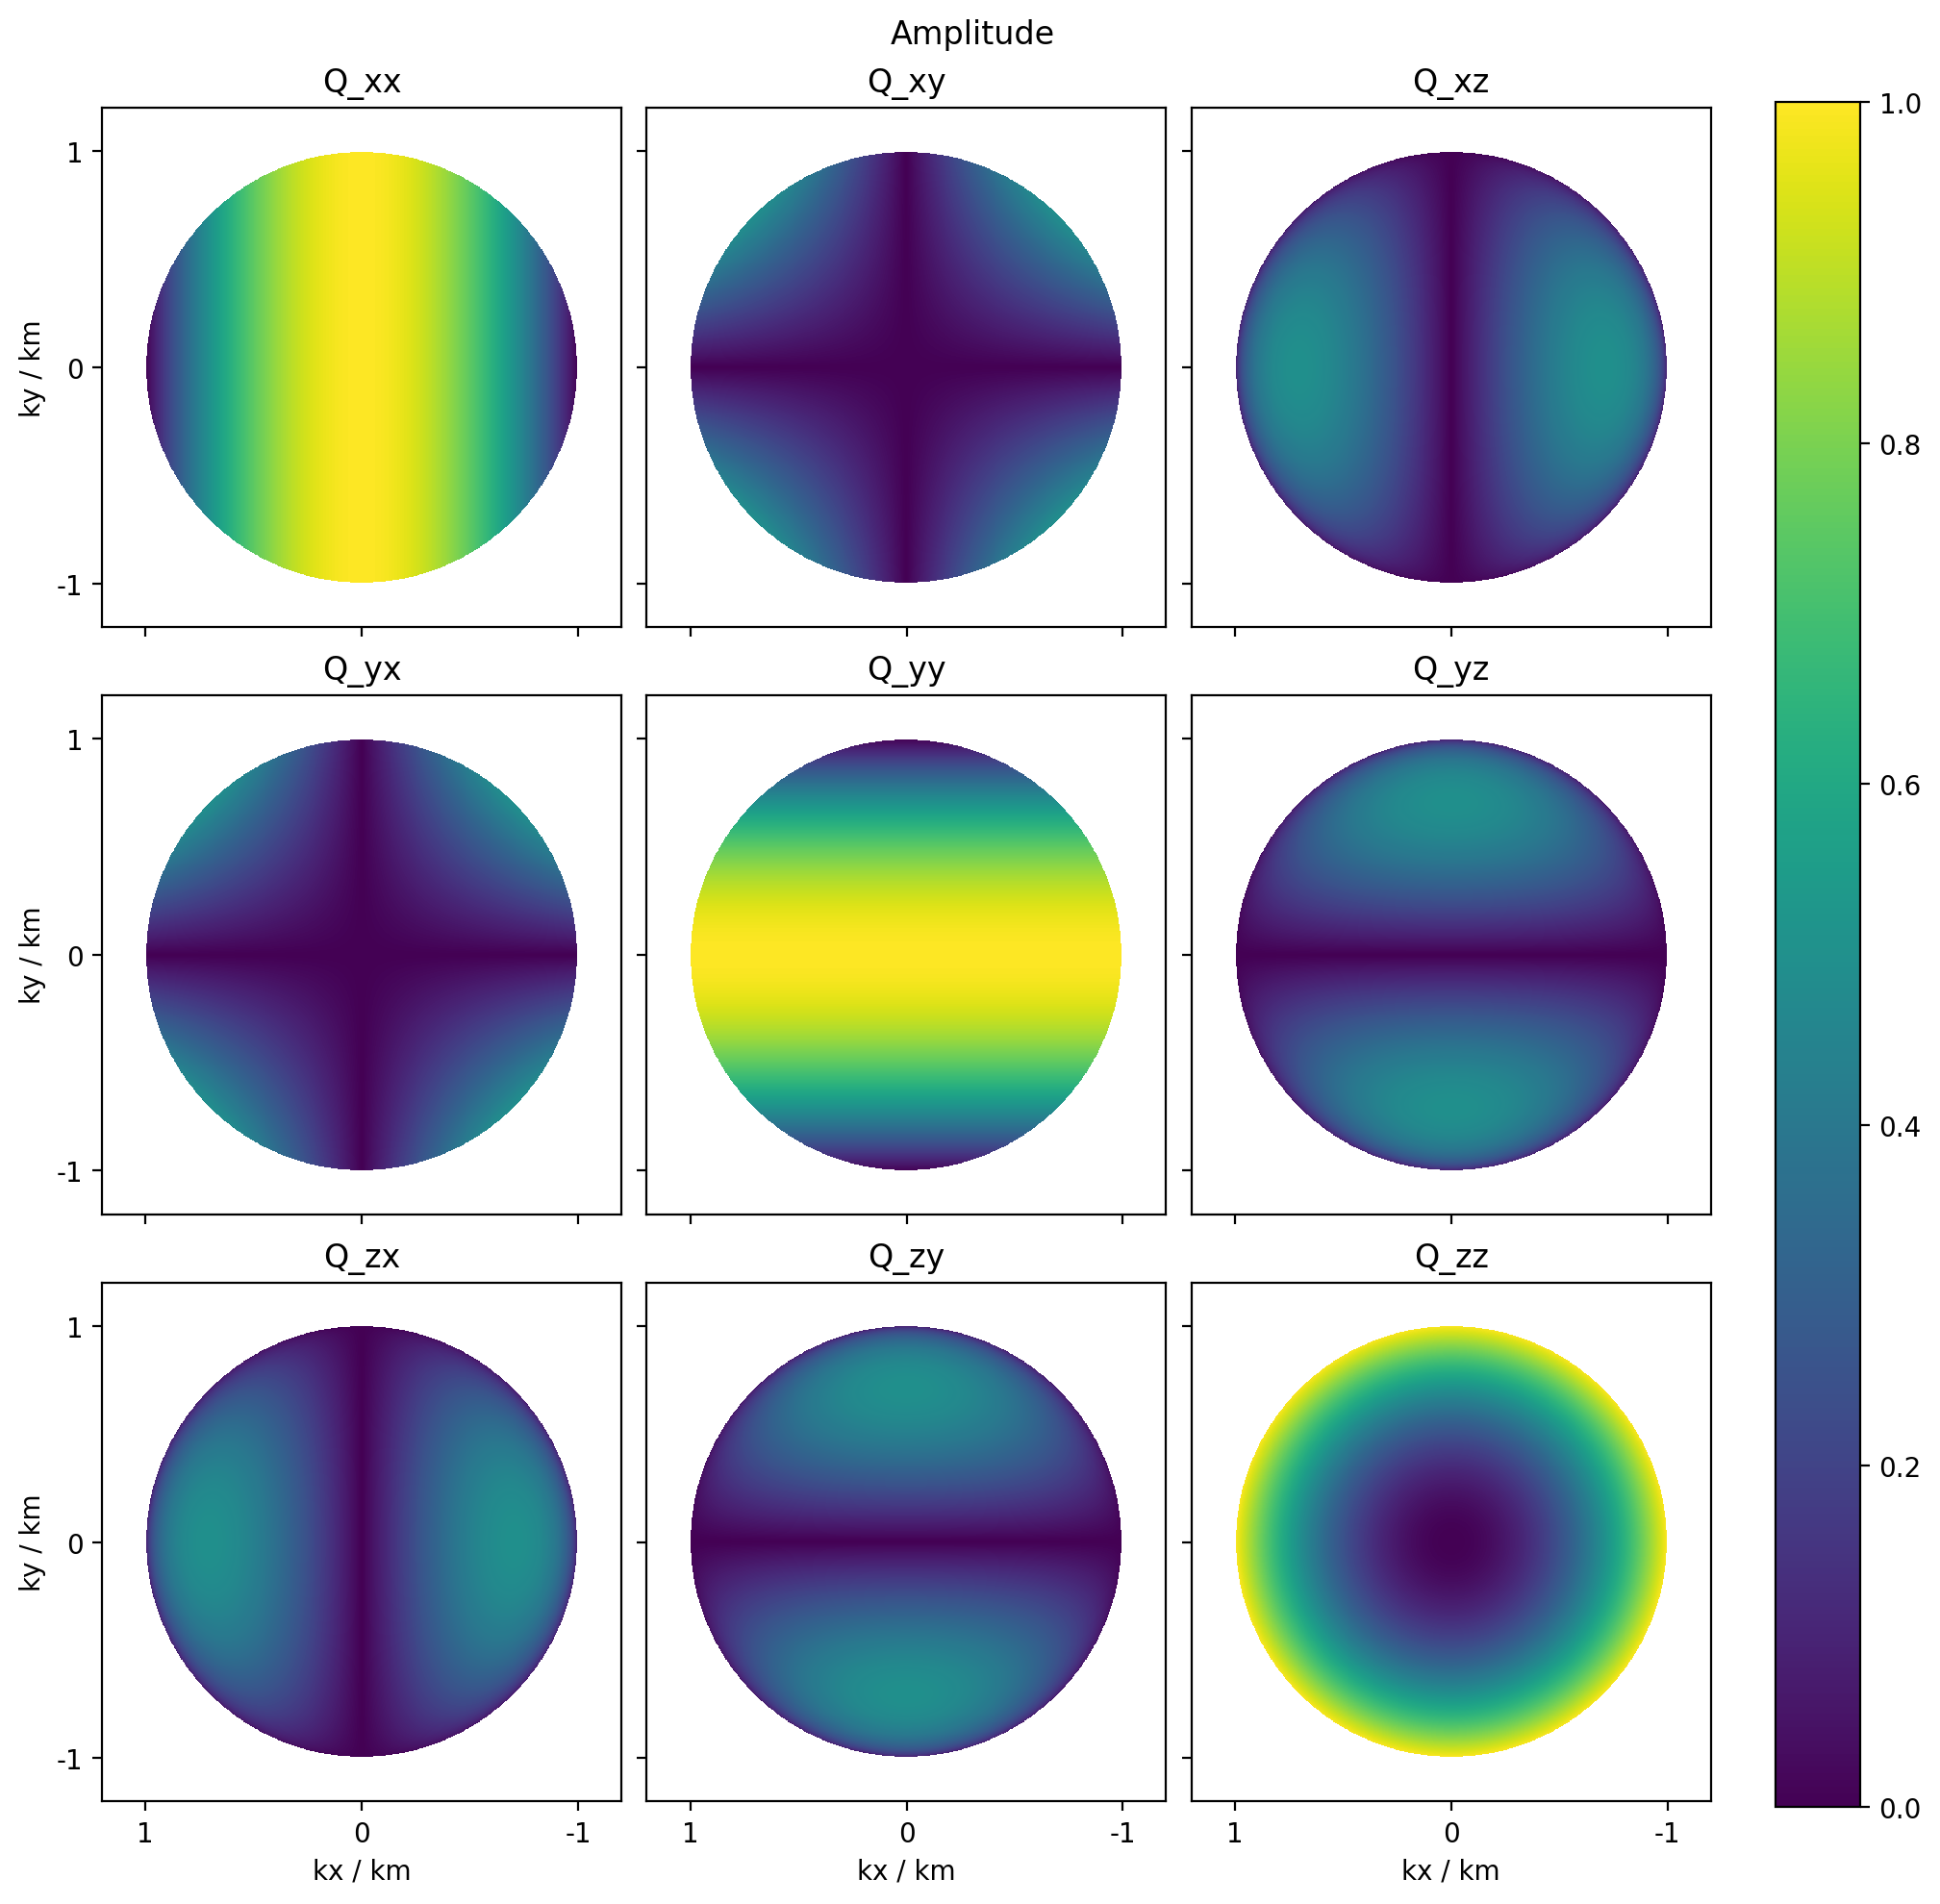

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True, layout="compressed")
dim = ["x", "y", "z"]
tick_locs = [np.argmin(np.abs(k + 1.0)), k.size//2, np.argmin(np.abs(k - 1.0))]

# Plotting amplitudes
for idx_y in range(3):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.imshow(jnp.abs(Q_plot[..., 2 - idx_y, 2 - idx_x]), vmin=0, vmax=1)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels([])
        ax.set_xticks(tick_locs)
        ax.set_yticklabels([])
        ax.set_title(f"Q_{dim[idx_y]}{dim[idx_x]}")

# Adding in labels
for idx_y in range(3):
    ax = axes[idx_y, 0]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels(["1", "0", "-1"])
    ax.set_ylabel("ky / km")

for idx_x in range(3):
    ax = axes[-1, idx_x]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(["1", "0", "-1"])
    ax.set_xlabel("kx / km")


fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.053, pad=0.04)
fig.suptitle("Amplitude")
plt.show()

The amplitude matches the paper results!

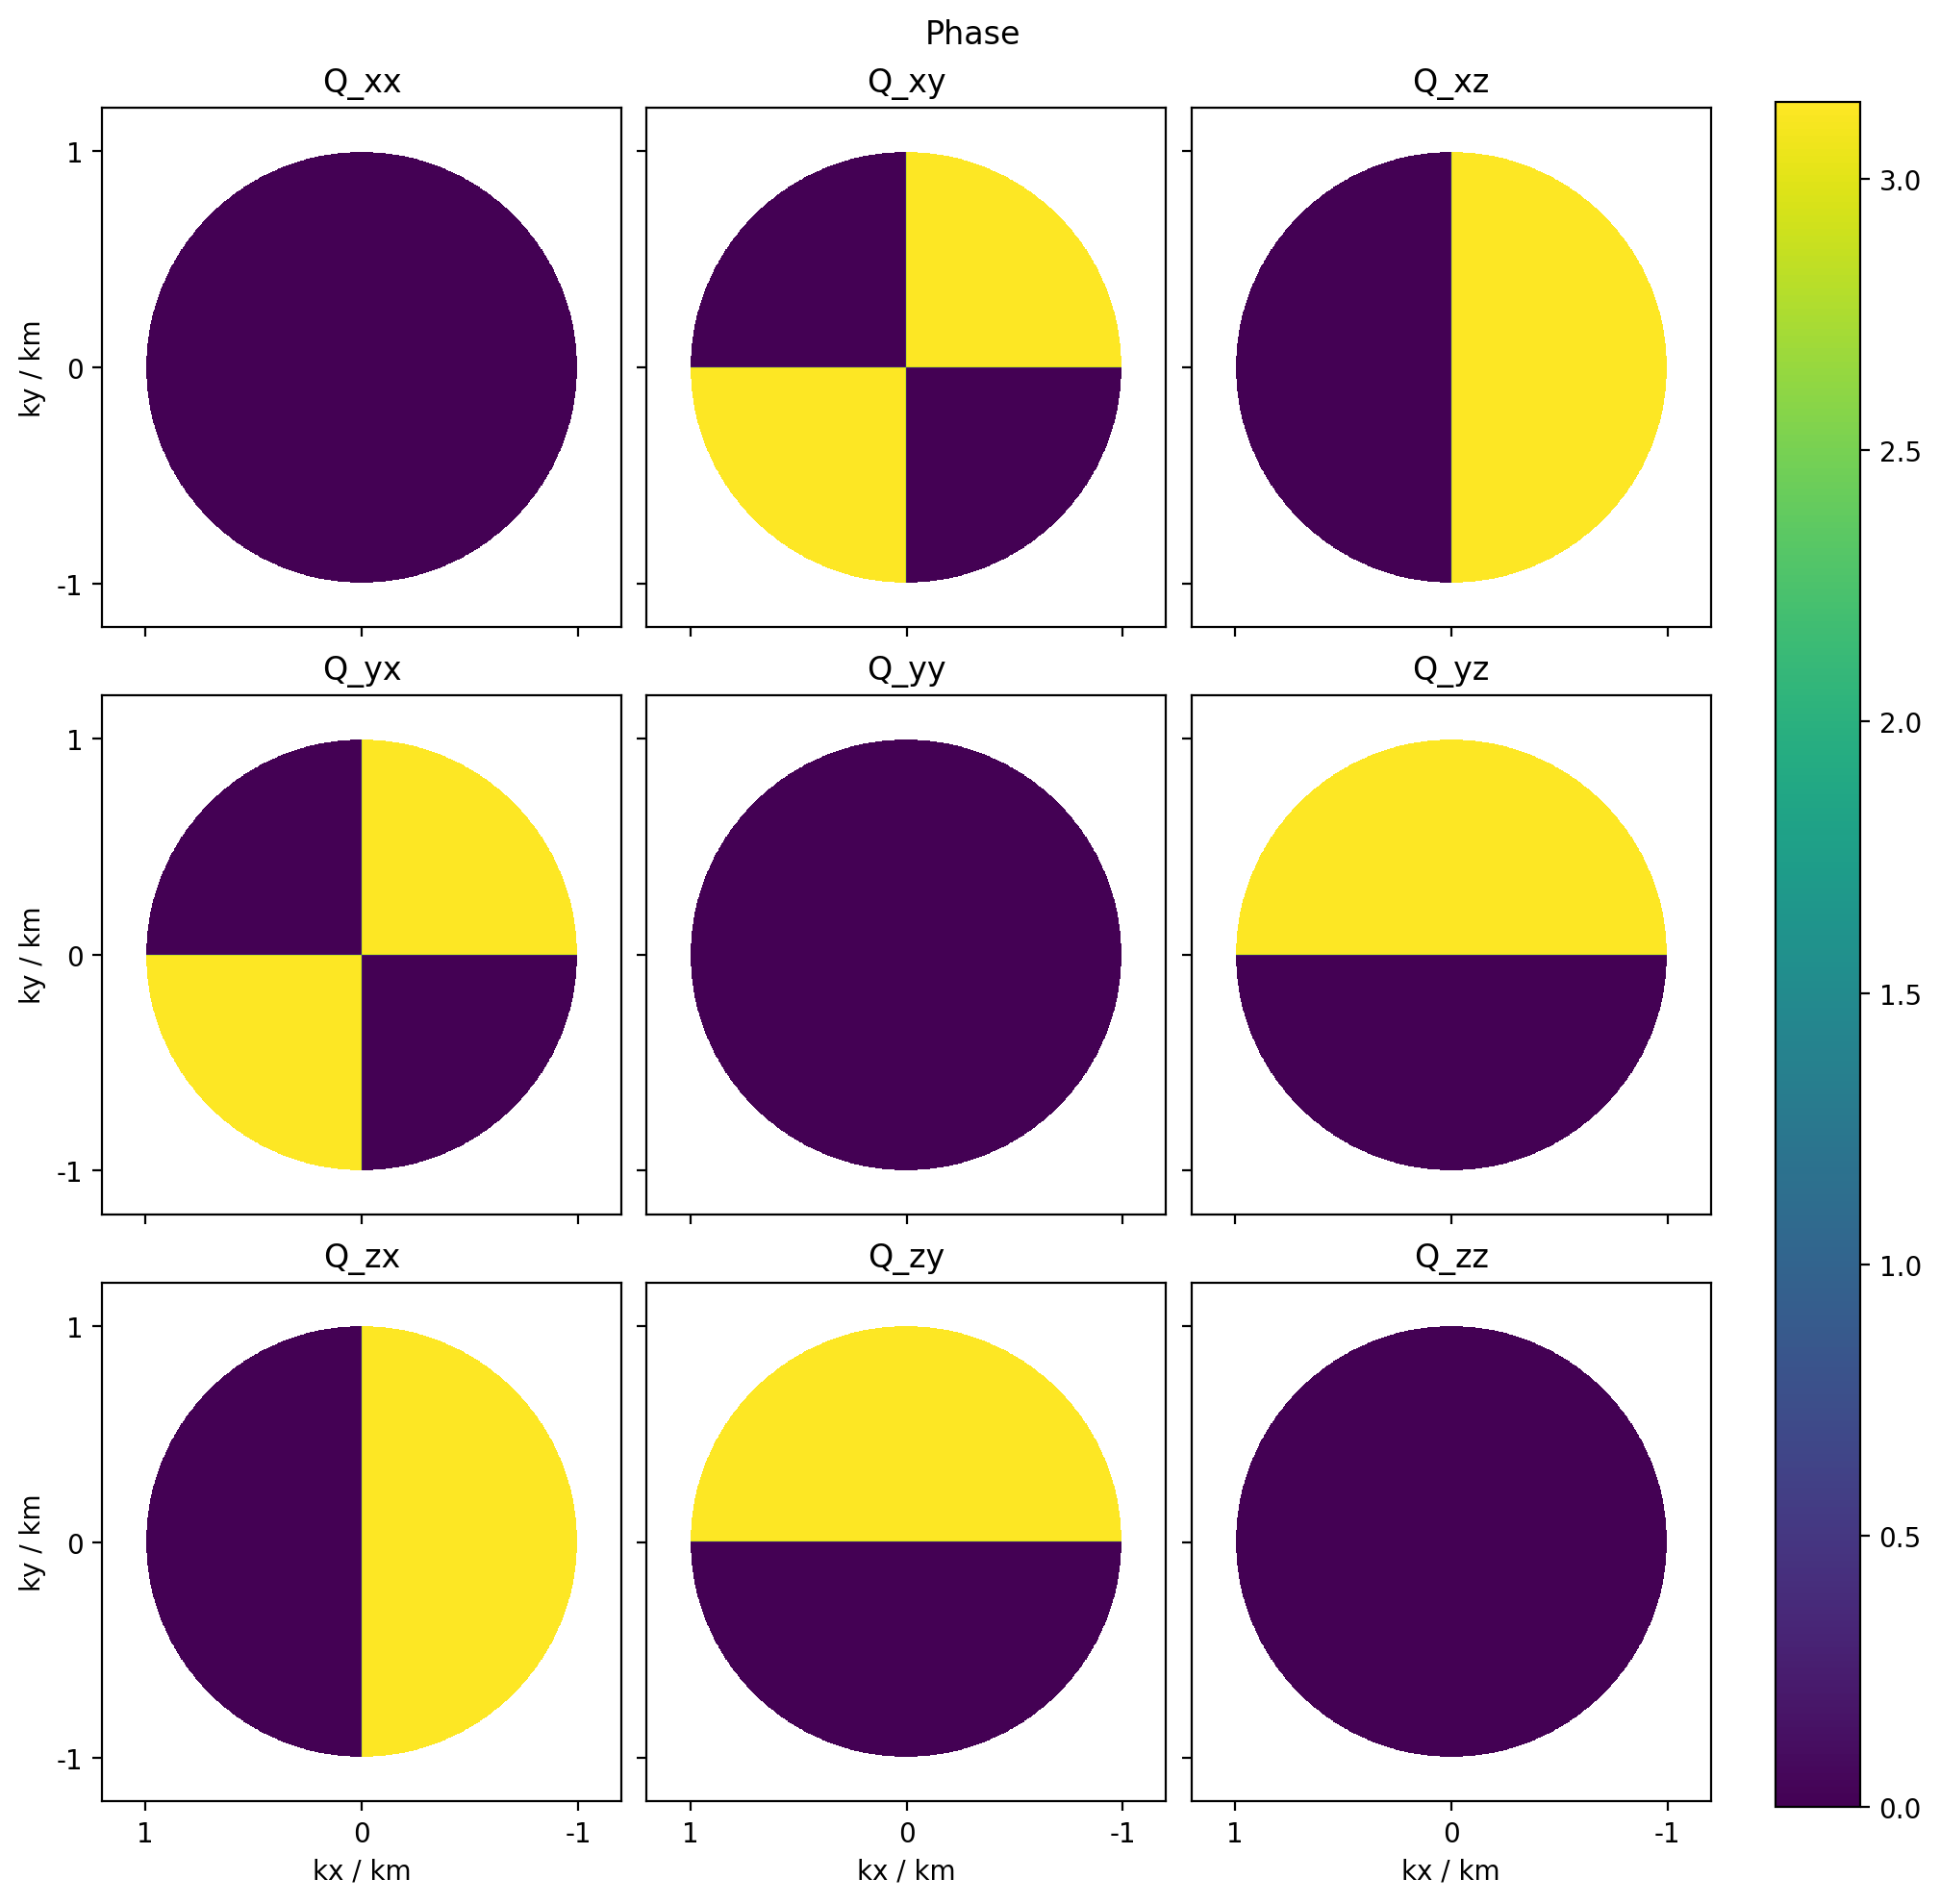

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True, layout="compressed")
dim = ["x", "y", "z"]
tick_locs = [np.argmin(np.abs(k + 1.0)), k.size//2, np.argmin(np.abs(k - 1.0))]

# Plotting amplitudes
for idx_y in range(3):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.imshow(jnp.angle(Q_plot[..., 2 - idx_y, 2 - idx_x]), vmin=0, vmax=jnp.pi)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels([])
        ax.set_yticks(tick_locs)
        ax.set_yticklabels([])
        ax.set_title(f"Q_{dim[idx_y]}{dim[idx_x]}")

# Adding in labels
for idx_y in range(3):
    ax = axes[idx_y, 0]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels(["1", "0", "-1"])
    ax.set_ylabel("ky / km")

for idx_x in range(3):
    ax = axes[-1, idx_x]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(["1", "0", "-1"])
    ax.set_xlabel("kx / km")


fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.053, pad=0.04)
fig.suptitle("Phase")
plt.show()

The phase *does not* match the paper; there's a mirroring around the y axis. This is actually an error in the paper: taking Qxy as an example, its defined as $Q_{xy} = -k_x k_y / k_m^2 \propto -k_x k_y$. In the upper right quadrant, both $k_x > 0$ and $k_y > 0$ and hence the sign of $Q_{xy}$ should be negative. In the paper however it is positive ($\phi=0$ corresponds to 1, $\phi=\pi$ corresponds to -1). Our figure is correct, and the paper is not. Their error is probably in the creation of the grid, having $y$ run from negative to positive (see comment in the code above).

We've matched the paper results, but we want to be clear that the chromatix kgrid also yields the same result. Especially given a factor of 2pi which may or may not appear.

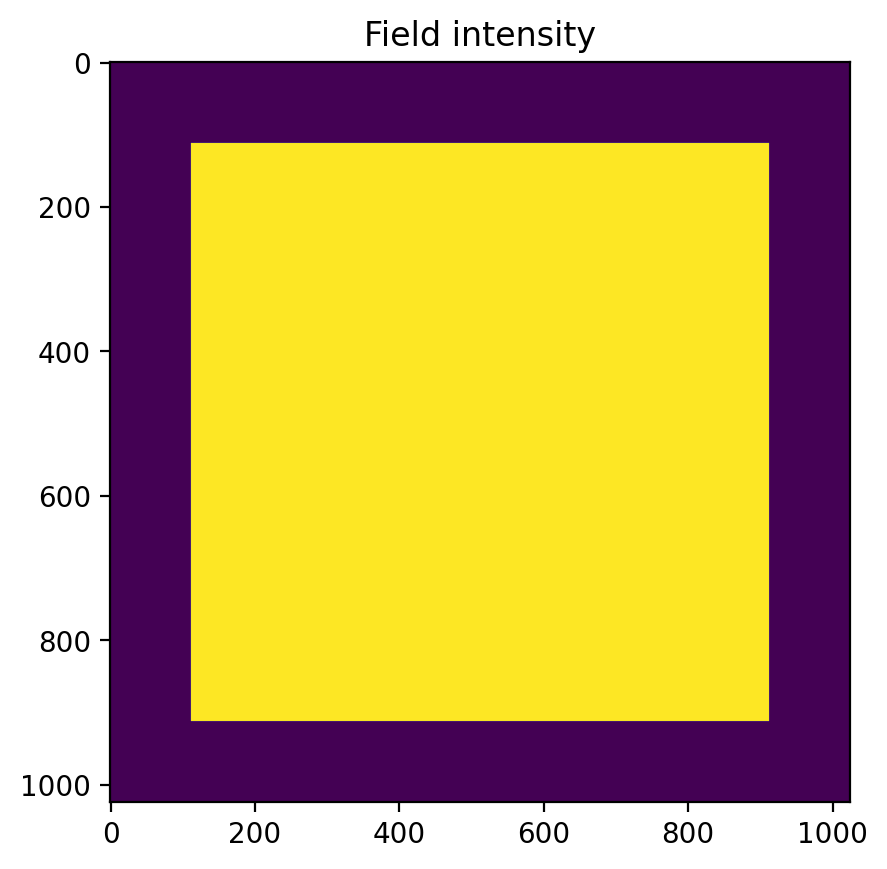

In [7]:
# Creating some point source 
field = cf.point_source(
    (1024, 1024),
    0.25,
    1.0,
    1.0,
    1.0,
    1.0,
    amplitude=cf.linear(1 / 2 * jnp.pi),
    scalar=False,
    pupil=lambda f: cf.square_pupil(f, 200),
)

# Plotting the intensity of the field
plt.imshow(field.intensity.squeeze())
plt.title("Field intensity")
plt.show()

In [8]:
# Let's make the full k_grid with chromatix
n = 1 / (2 * jnp.pi) # we set n = 2pi so that km = 1 as above
km = 2 * jnp.pi * n / field.spectrum

# We chop off evanescent waves
# Chromatix k_grid does NOT include 2 pi factor; this is where the 2pi below come from
k_grid = 2 * jnp.pi * field.k_grid
kz = jnp.sqrt(jnp.maximum(0.0, km**2 -  jnp.sum(k_grid**2, axis=0, keepdims=True))) 
k_grid =  jnp.concatenate([kz, k_grid], axis=0)

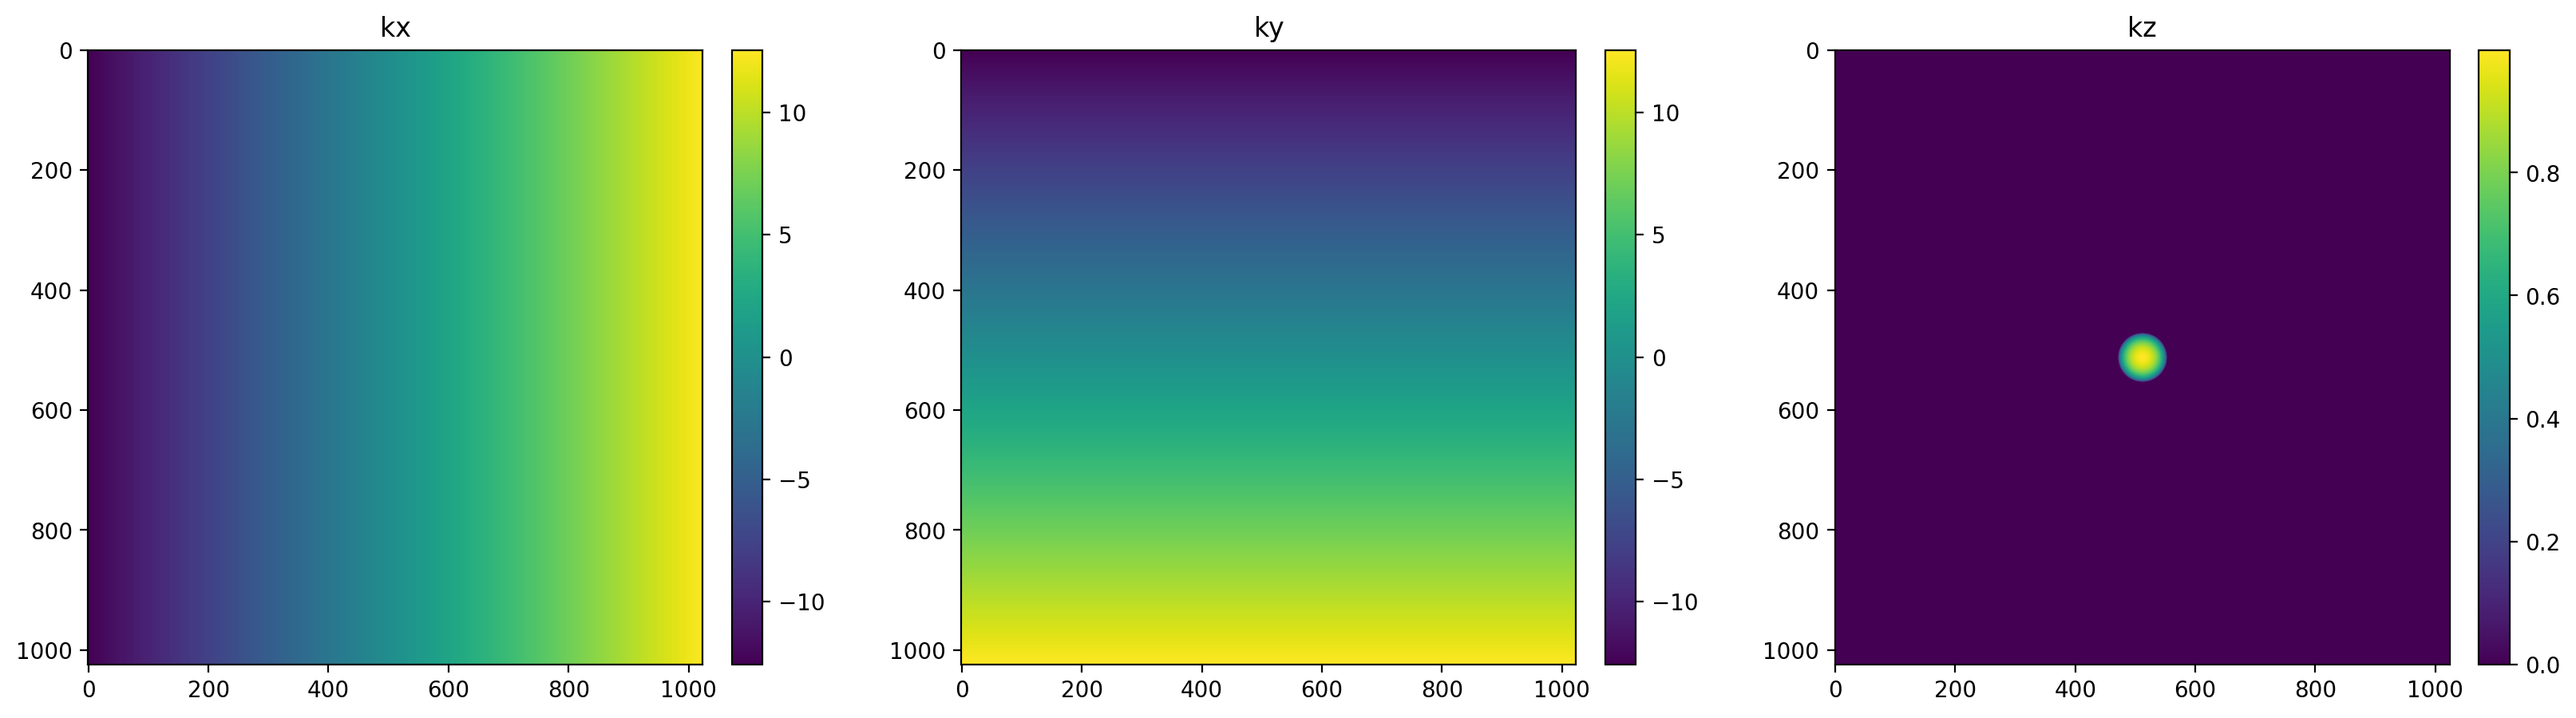

In [9]:
# Let's plot the coordinates
# We see that y is inverted - not a problem but do have to remember
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(k_grid[2].squeeze())
plt.title("kx")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(k_grid[1].squeeze())
plt.title("ky")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(k_grid[0].squeeze())
plt.title("kz")
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

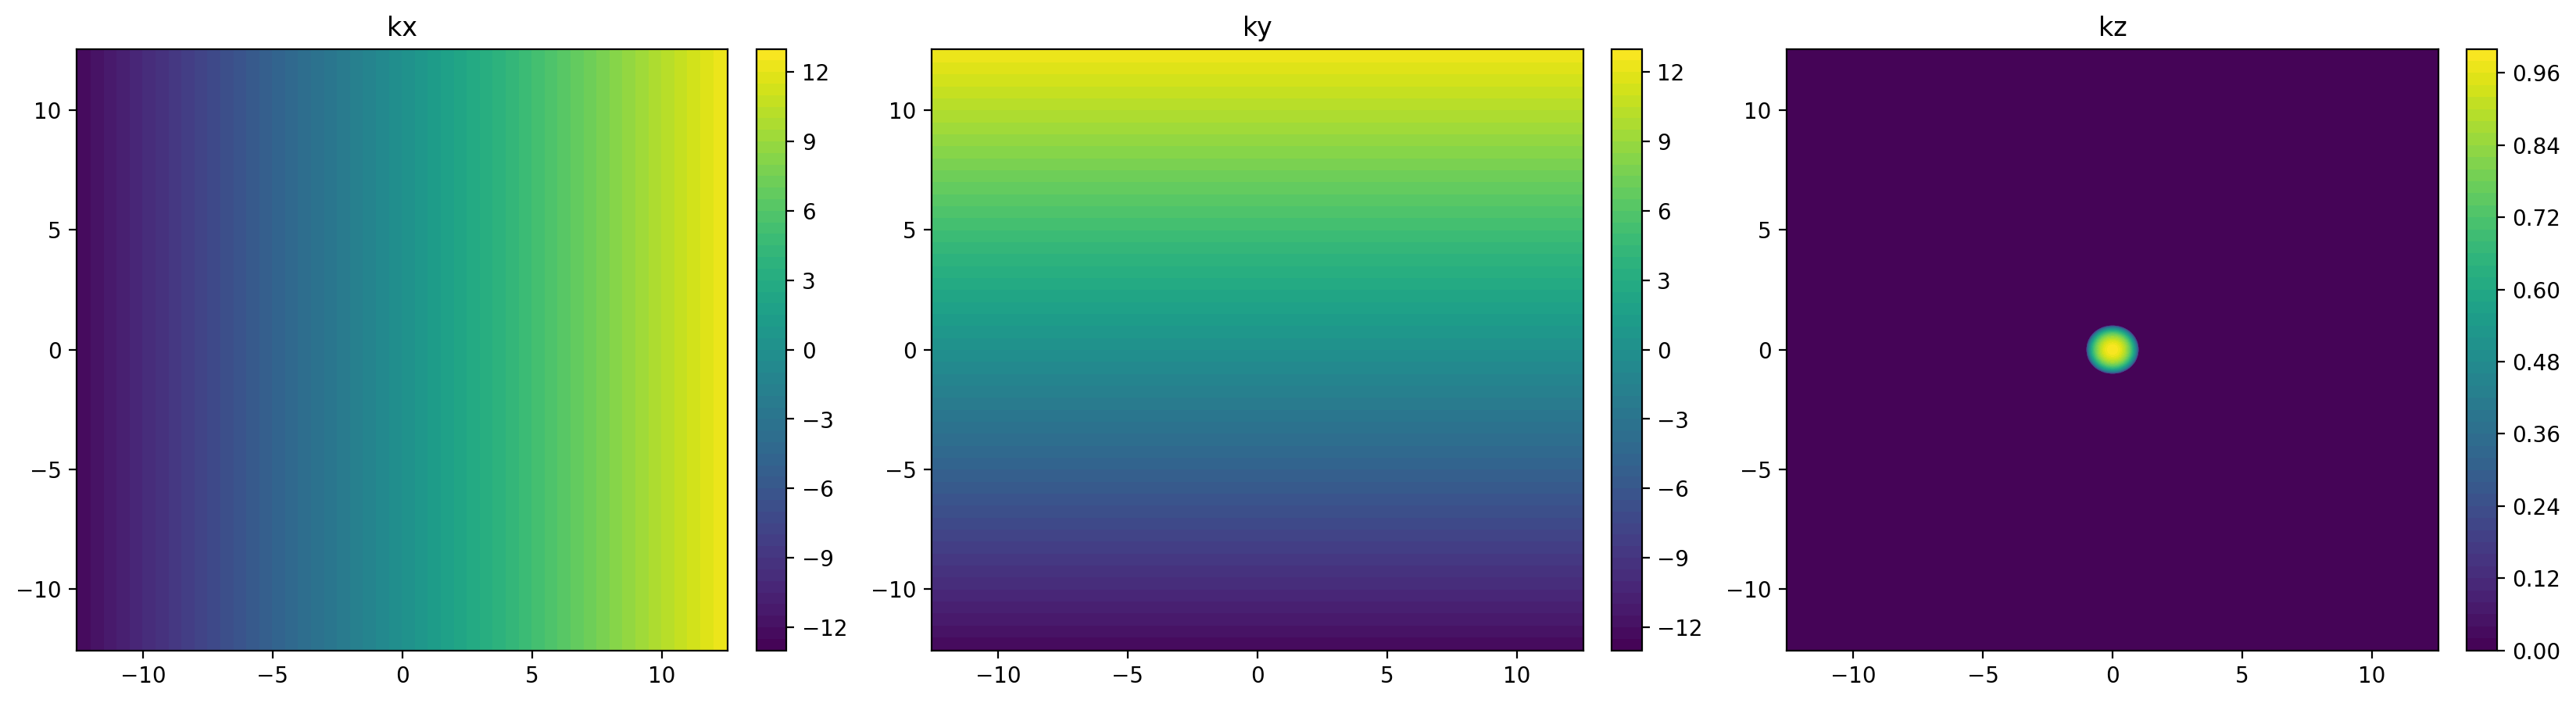

In [10]:
# Now let's plot the same, but in normalised coordinates 
k_plot = (k_grid[1:][::-1] / km).squeeze()
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.contourf(*k_plot, k_grid[2].squeeze(), levels=50)
plt.title("kx")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.contourf(*k_plot, k_grid[1].squeeze(), levels=50)
plt.title("ky")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.contourf(*k_plot, k_grid[0].squeeze(), levels=50)
plt.title("kz")
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [11]:
# Getting Q 
Q = PTFT(k_grid, km=km)

# We set 0 to NaN to plot clearer
Q_plot = jnp.where(Q == 0, jnp.nan, Q).squeeze()

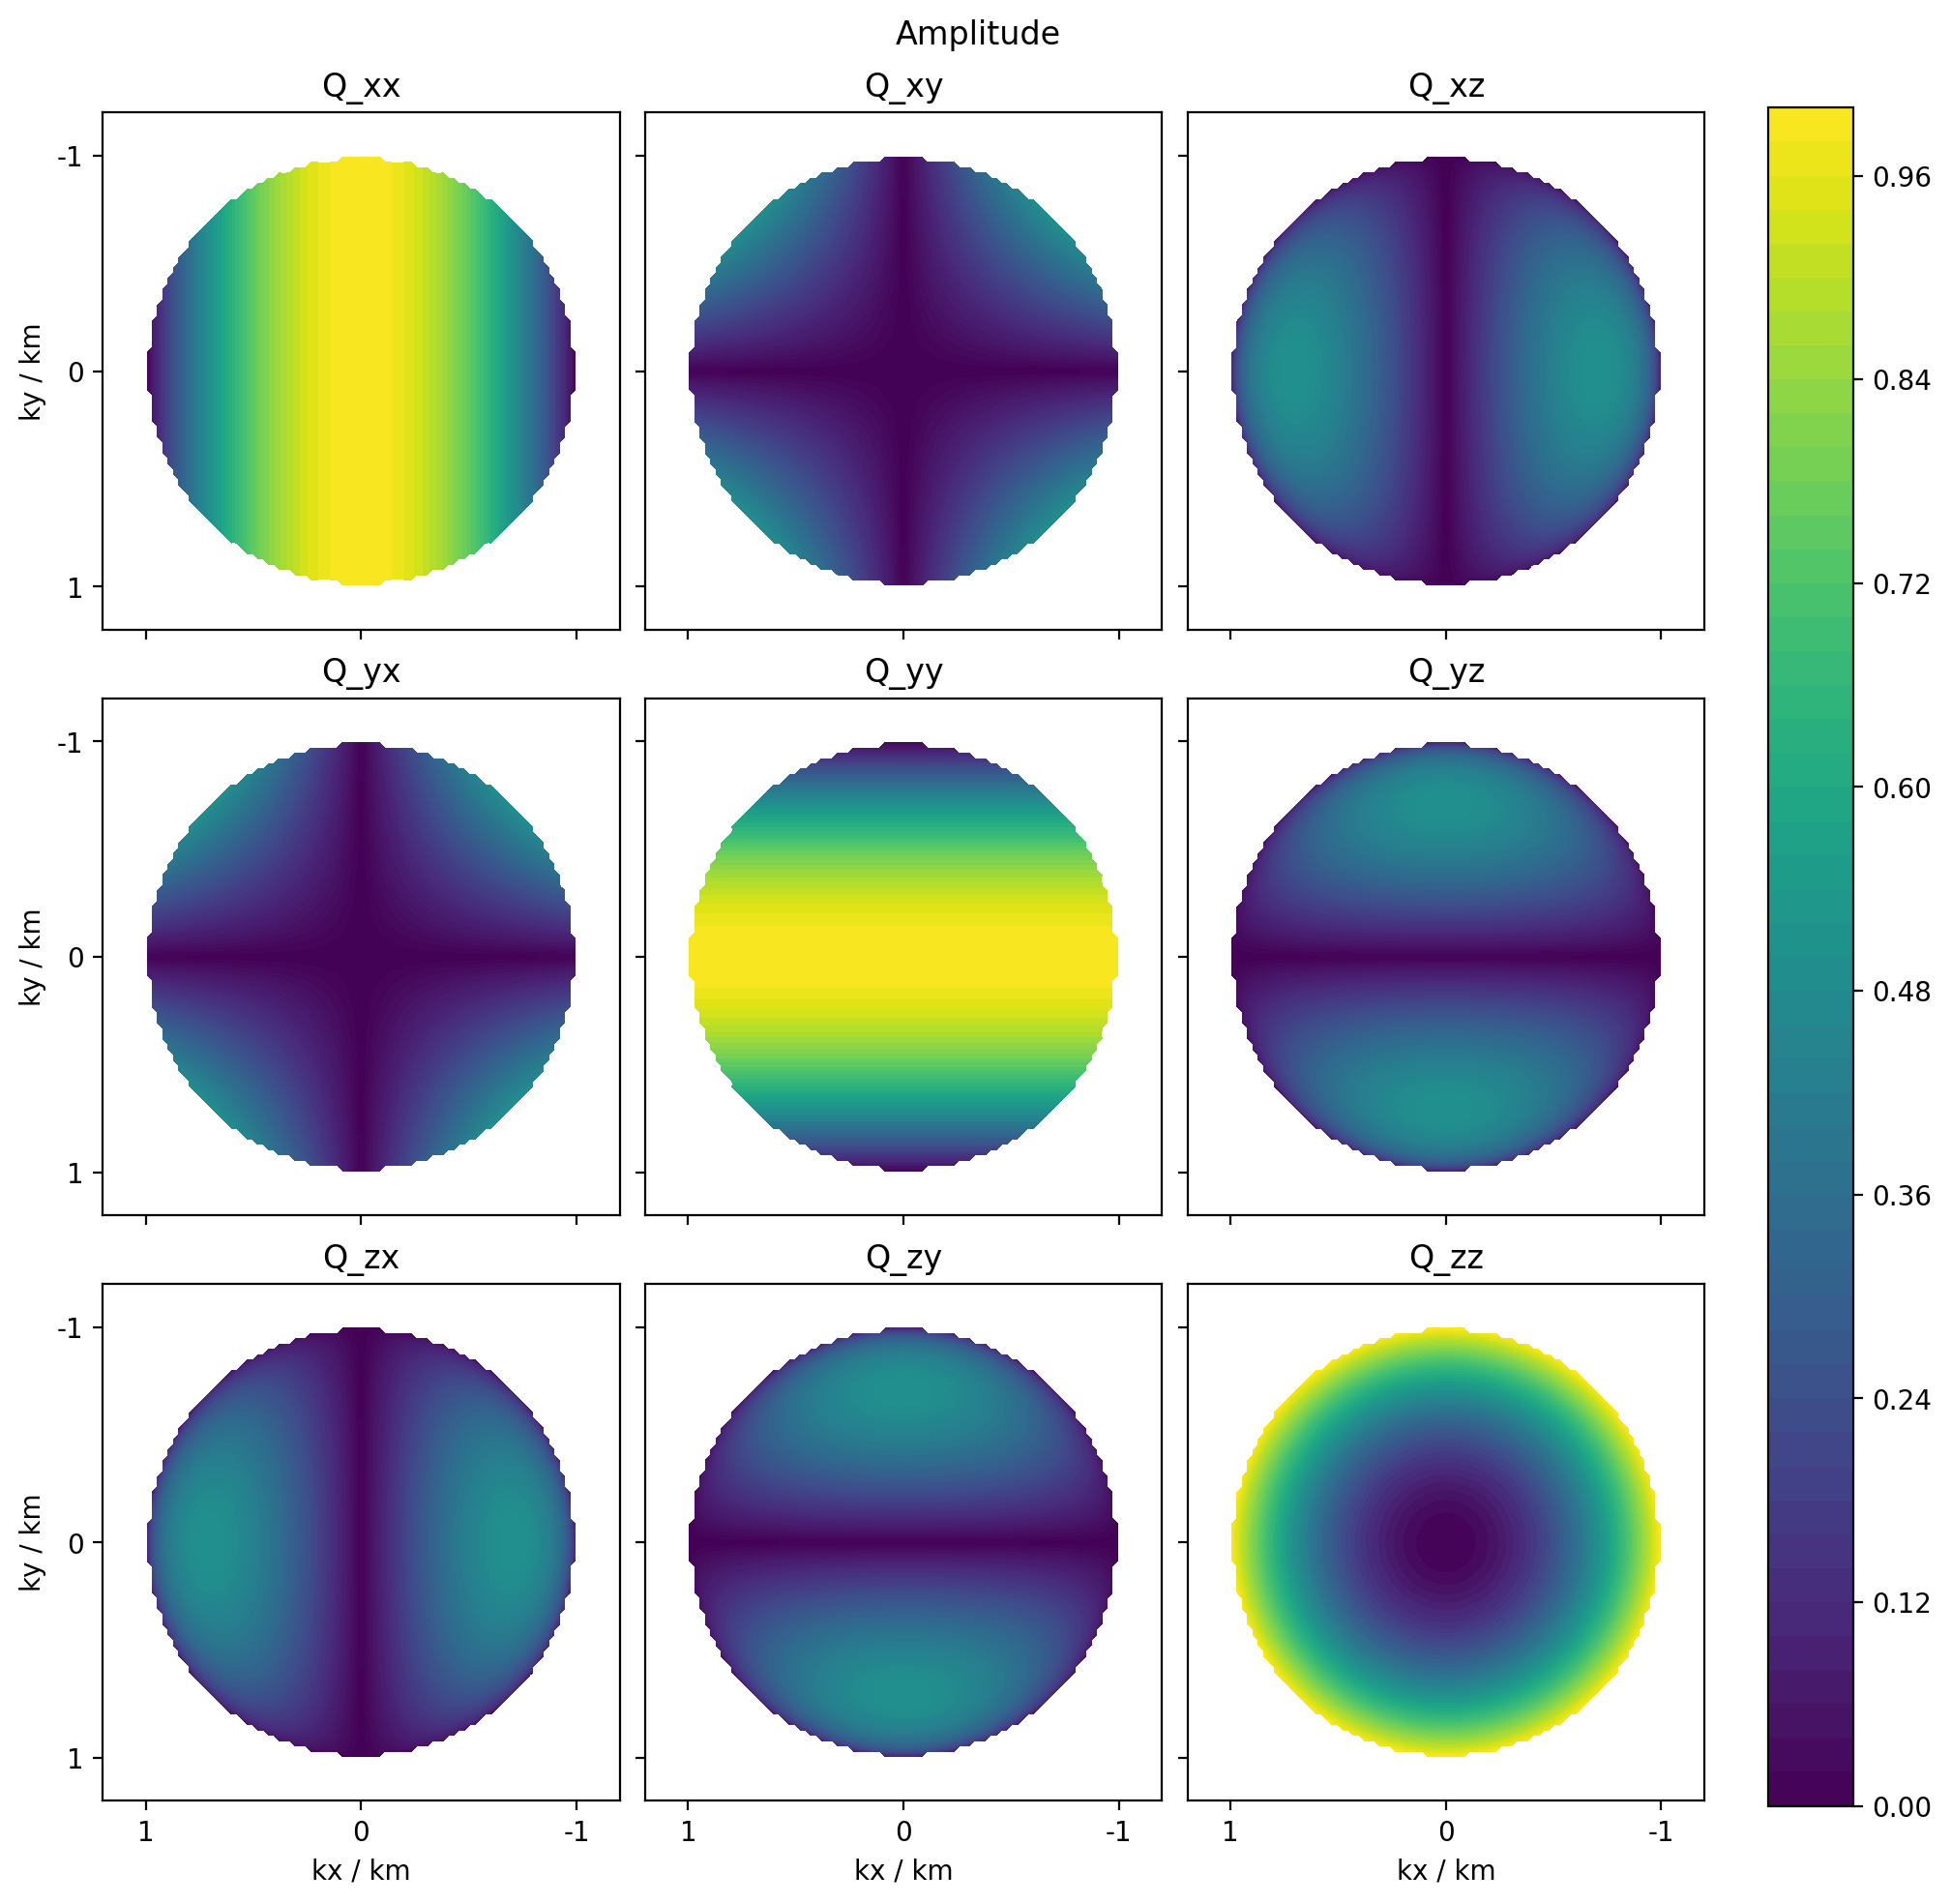

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True, layout="compressed")
dim = ["x", "y", "z"]
tick_locs = [-1, 0, 1]

# Plotting amplitudes
for idx_y in range(3):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.contourf(*k_plot, jnp.abs(Q_plot[..., 2 - idx_y, 2 - idx_x]), levels=50, vmin=0, vmax=1)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels([])
        ax.set_xticks(tick_locs)
        ax.set_yticklabels([])
        ax.set_title(f"Q_{dim[idx_y]}{dim[idx_x]}")
        ax.set_aspect("equal")

        # We zoom cause otherwise we don't see much
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])

# Adding in labels
for idx_y in range(3):
    ax = axes[idx_y, 0]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels(["1", "0", "-1"])
    ax.set_ylabel("ky / km")

for idx_x in range(3):
    ax = axes[-1, idx_x]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(["1", "0", "-1"])
    ax.set_xlabel("kx / km")


fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.053, pad=0.04)
fig.suptitle("Amplitude")
plt.show()

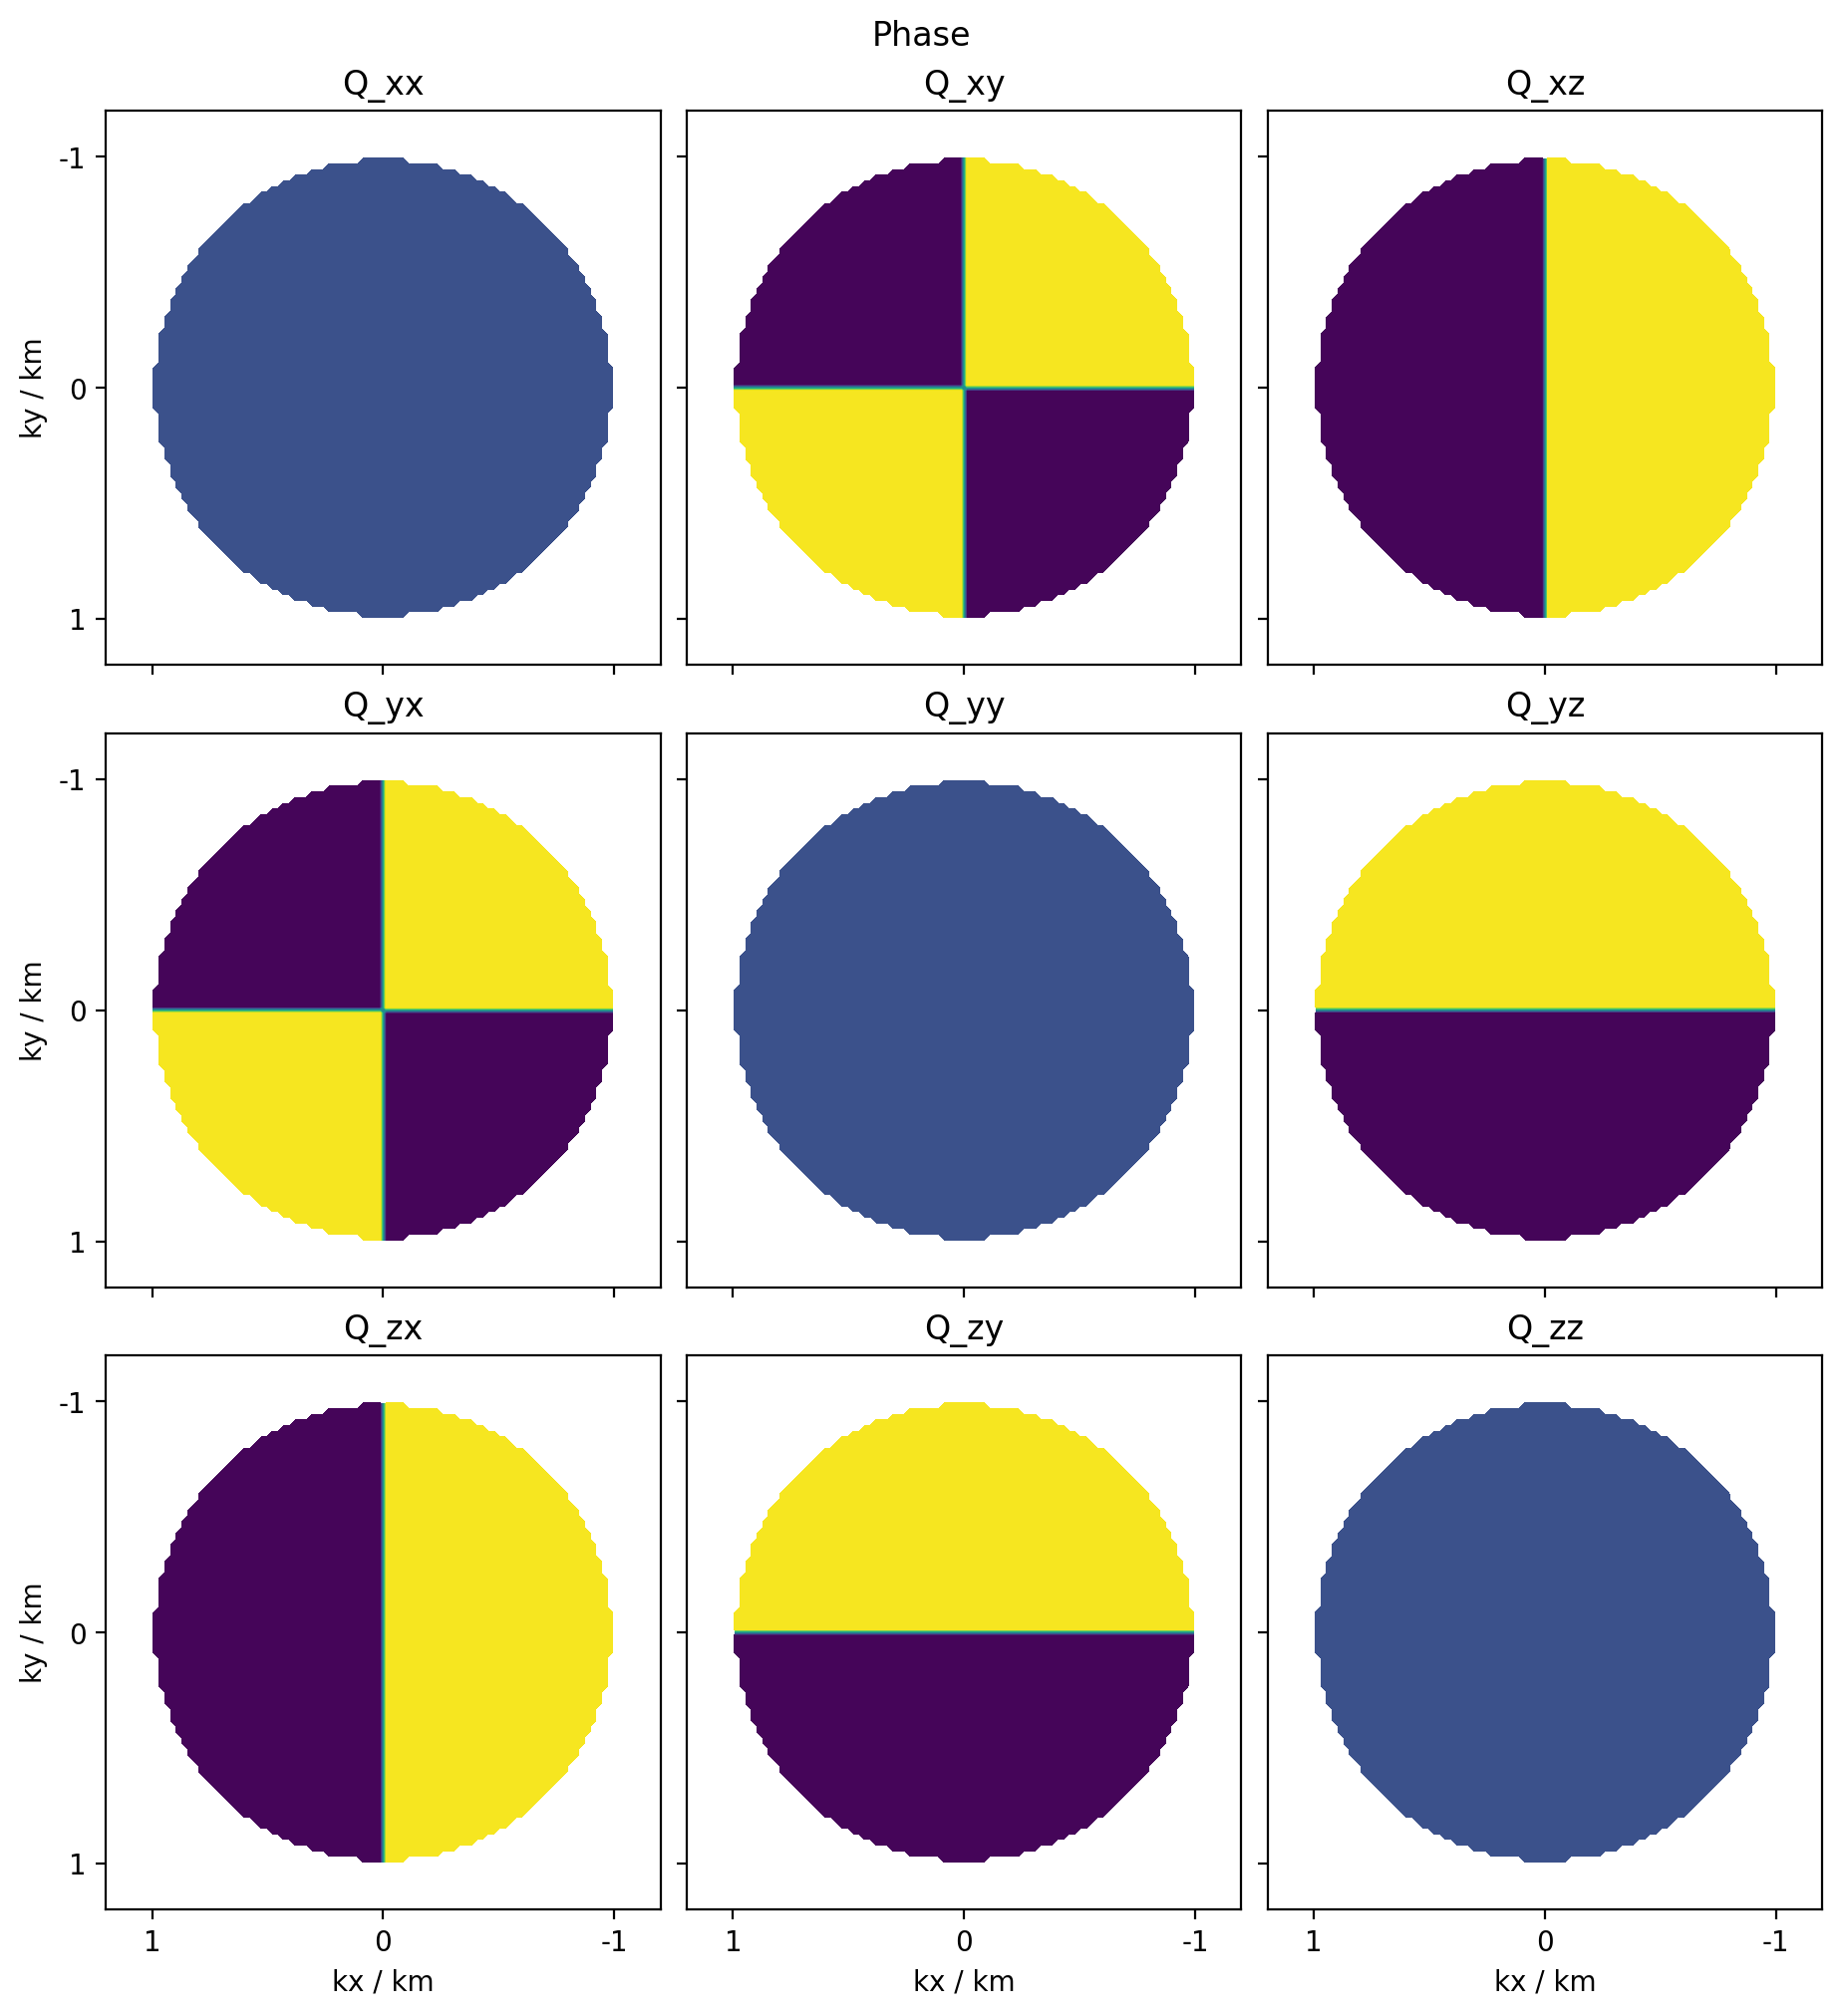

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True, layout="compressed")
dim = ["x", "y", "z"]
tick_locs = [-1, 0, 1]

# Plotting amplitudes
for idx_y in range(3):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.contourf(*k_plot, jnp.angle(Q_plot[..., 2 - idx_y, 2 - idx_x]), levels=50)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels([])
        ax.set_xticks(tick_locs)
        ax.set_yticklabels([])
        ax.set_title(f"Q_{dim[idx_y]}{dim[idx_x]}")
        ax.set_aspect("equal")

        # We zoom cause otherwise we don't see much
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])

# Adding in labels
for idx_y in range(3):
    ax = axes[idx_y, 0]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels(["1", "0", "-1"])
    ax.set_ylabel("ky / km")

for idx_x in range(3):
    ax = axes[-1, idx_x]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(["1", "0", "-1"])
    ax.set_xlabel("kx / km")


#fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.053, pad=0.04)
fig.suptitle("Phase")
plt.show()

Looks like a great match! If we include the 2pi as per above chromatix generates the right kernel.